In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt


from utils.date import convert_to_str_days, convert_days_to_str
from utils.dataloader import load_indirect_WUE, load_carbon, load_direct_WUE

## 0. Utils

In [2]:
def estimate_total_water(power, num_days, indirectWue, directWue):
    wue_array     = np.zeros(11)

    for i in range(1,12):
        start_str     = "2022-{:0>2d}-01T01".format(i)
        start_ts      = convert_to_str_days(start_str)
        end_ts        = num_days + start_ts
        end_date_str  = convert_days_to_str(end_ts)

        # Convert days to hours
        start_ts     *= 24
        end_ts       *= 24
        num_timeslot  = num_days*24

        time_array    = np.arange(1, 1+num_timeslot)/24

        in_wue_i  = indirectWue[start_ts:end_ts].sum()
        dir_wue_i = directWue[start_ts:end_ts].sum()
        wue_i     = in_wue_i + dir_wue_i

        wue_i    *= power
        wue_array[i-1] = wue_i
    return wue_array

def load_total_water(loc_name):
    fuel_mix_path = "data/fuelmix/{}_year_2022.csv".format(loc_name.split("_")[-1])
    weather_path  = "data/weather/{}.csv".format(loc_name)
    dc_loc        = loc_name.split("_")[1]

    # Suppose the datacenter PUE is ~1.1
    indirectWue = load_indirect_WUE(fuel_mix_path, dc_loc) * 1.1
    indirectWue = np.roll(indirectWue, -7)      # UTC to PDT time

    directWue = load_direct_WUE(weather_path)
    directWue = np.roll(directWue, -7)
    
    return directWue, indirectWue

def load_total_carbon(loc_name):
    
    fuel_mix_path = "data/fuelmix/{}_year_2022.csv".format(loc_name.split("_")[-1])
    weather_path  = "data/weather/{}.csv".format(loc_name)
    dc_loc        = loc_name.split("_")[1]

    # Suppose the datacenter PUE is ~1.1
    carbon_curve = load_carbon(fuel_mix_path, dc_loc)
    carbon_curve = np.roll(carbon_curve, -7)    # UTC to PDT time
    
    return carbon_curve

## 1. Total Water

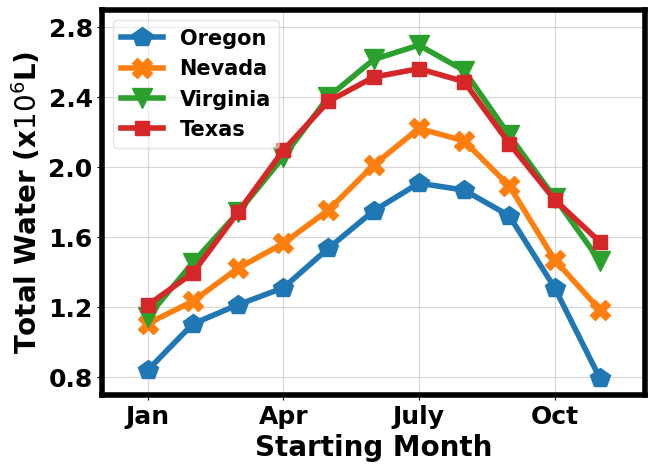

In [5]:
# 4S2_Oregan_NW.csv    HND_Nevada_CAL.csv   JYO_virginia_PJM.csv
# FTY_Georgia_SE.csv   JWY_Texas_ERCO.csv

loc_name_list = ["4S2_Oregan_NW", "HND_Nevada_CAL", "JYO_virginia_PJM", "JWY_Texas_ERCO"]
wue_array_list = []

for loc_name in loc_name_list:
    power        = 295    # 1024*0.289kW
    num_days     = 58     # Number of Hours

    directWue, indirectWue = load_total_water(loc_name)
    wue_array    = estimate_total_water(power, num_days, indirectWue, directWue)

    wue_array_list.append(wue_array)

    
fig, ax1 = plt.subplots(figsize =(7, 5))


ax1.set_xlim([-1,11])
name_list   = ["Oregon", "Nevada", "Virginia", "Texas"]
marker_list = ["p", "X", "v", "s"]
msize_list  = [15,15,15,10]
for i in range(4):
    wue_array = wue_array_list[i]
    ax1.plot(wue_array, linewidth=4, marker=marker_list[i], 
             markersize=msize_list[i], label=name_list[i])

ax1.set_xticks([0,3,6,9], labels = ["Jan", "Apr", "July", "Oct"],fontsize = 18,fontweight='bold')
# ax1.set_xticks(np.arange(0,11), labels = ["".format(i) for i in np.arange(0,11)],fontsize = 18,fontweight='bold', minor=True)

ax1.set_ylabel(r"Total Water (x$10^6$L)", fontweight ='bold', fontsize=20)
ax1.set_xlabel("Starting Month", fontweight ='bold', fontsize=20)

ax1.set_yticks(np.arange(0.8,2.91, 0.4)*1e6, labels = ["{:.1f}".format(i) for i in np.arange(0.8,2.91, 0.4) ],
               fontsize = 18,fontweight='bold')
ax1.set_ylim([0.7*1e6,2.9*1e6])

ax1.spines['bottom'].set_linewidth(4);
ax1.spines['left'].set_linewidth(4);
ax1.spines['right'].set_linewidth(4);
ax1.spines['top'].set_linewidth(4);


handles,labels = ax1.get_legend_handles_labels()

lengend_order = [j for j in range(len(labels))]
sorted_legends = [labels[i] for i in lengend_order]
sorted_handles = [handles[i] for i in lengend_order]
leg = ax1.legend(sorted_handles,sorted_legends,prop={'size': 15, 'weight':'bold'},ncol=1,
           framealpha=0.5,loc='upper left')

ax1.grid(which='both', alpha=0.5)
# plt.savefig("output/example/total_water_LaMDA.pdf", bbox_inches='tight')
plt.show()

## 2. Onsite Water

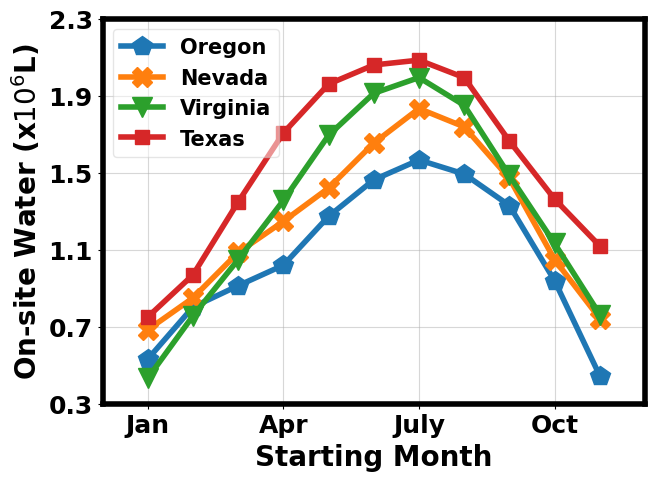

In [6]:
# 4S2_Oregan_NW.csv    HND_Nevada_CAL.csv   JYO_virginia_PJM.csv
# FTY_Georgia_SE.csv   JWY_Texas_ERCO.csv

loc_name_list = ["4S2_Oregan_NW", "HND_Nevada_CAL", "JYO_virginia_PJM", "JWY_Texas_ERCO"]
wue_array_list = []

for loc_name in loc_name_list:
    power        = 295    # 1024*0.289kW
    num_days     = 58     # Number of Hours

    directWue, indirectWue = load_total_water(loc_name)
    # Set indirect WUE as zeros
    indirectWue  = 0*indirectWue
    wue_array    = estimate_total_water(power, num_days, indirectWue, directWue)
    
    wue_array_list.append(wue_array)

    
fig, ax1 = plt.subplots(figsize =(7, 5))


ax1.set_xlim([-1,11])
name_list = ["Oregon", "Nevada", "Virginia", "Texas"]
# for i in range(4):
#     wue_array = wue_array_list[i]
#     ax1.plot(wue_array, linewidth=4, marker="p", markersize=15, label=name_list[i])
marker_list = ["p", "X", "v", "s"]
msize_list  = [15,15,15,10]
for i in range(4):
    wue_array = wue_array_list[i]
    ax1.plot(wue_array, linewidth=4, marker=marker_list[i], 
             markersize=msize_list[i], label=name_list[i])

ax1.set_xticks([0,3,6,9], labels = ["Jan", "Apr", "July", "Oct"],fontsize = 18,fontweight='bold')
# ax1.set_xticks(np.arange(0,11), labels = ["".format(i) for i in np.arange(0,11)],fontsize = 18,fontweight='bold', minor=True)

ax1.set_ylabel(r"On-site Water (x$10^6$L)", fontweight ='bold', fontsize=20)
ax1.set_xlabel("Starting Month", fontweight ='bold', fontsize=20)

ax1.set_yticks(np.arange(0.3,2.31, 0.4)*1e6, labels = ["{:.1f}".format(i) for i in np.arange(0.3,2.31, 0.4) ],
               fontsize = 18,fontweight='bold')
ax1.set_ylim([0.3*1e6,2.3*1e6])

ax1.spines['bottom'].set_linewidth(4);
ax1.spines['left'].set_linewidth(4);
ax1.spines['right'].set_linewidth(4);
ax1.spines['top'].set_linewidth(4);

handles,labels = ax1.get_legend_handles_labels()

lengend_order = [j for j in range(len(labels))]
sorted_legends = [labels[i] for i in lengend_order]
sorted_handles = [handles[i] for i in lengend_order]
leg = ax1.legend(sorted_handles,sorted_legends,prop={'size': 15, 'weight':'bold'},ncol=1,
           framealpha=0.5,loc='upper left')

ax1.grid(which='both', alpha=0.5)
# plt.savefig("output/example/onsite_water_LaMDA.pdf", bbox_inches='tight')
plt.show()

## 3.Total Carbon

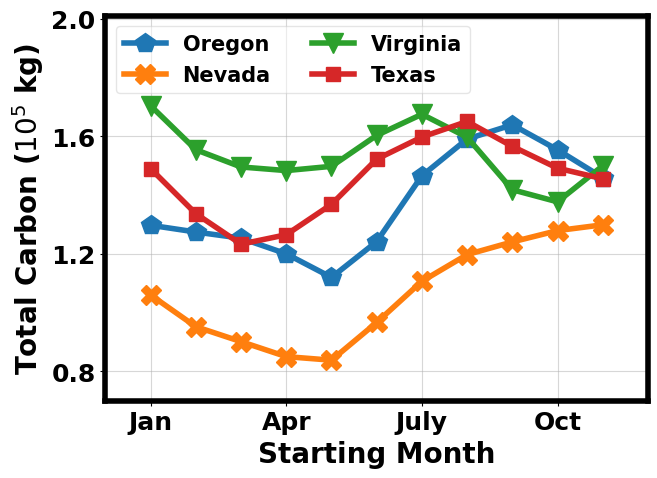

In [7]:
# 4S2_Oregan_NW.csv    HND_Nevada_CAL.csv   JYO_virginia_PJM.csv
# FTY_Georgia_SE.csv   JWY_Texas_ERCO.csv

loc_name_list = ["4S2_Oregan_NW", "HND_Nevada_CAL", "JYO_virginia_PJM", "JWY_Texas_ERCO"]
wue_array_list = []

for loc_name in loc_name_list:
    power        = 295    # 1024*0.289kW
    num_days     = 58     # Number of Hours

    directWue, _ = load_total_water(loc_name)
    carbon_curve = load_total_carbon(loc_name)
    
    indirectWue  = directWue*0
    directWue    = directWue*0 + carbon_curve
    
    wue_array    = estimate_total_water(power, num_days, indirectWue, directWue)

    wue_array_list.append(wue_array)

    
fig, ax1 = plt.subplots(figsize =(7, 5))


ax1.set_xlim([-1,11])
name_list = ["Oregon", "Nevada", "Virginia", "Texas"]
marker_list = ["p", "X", "v", "s"]
msize_list  = [15,15,15,10]
for i in range(4):
    wue_array = wue_array_list[i]
    ax1.plot(wue_array, linewidth=4, marker=marker_list[i], 
             markersize=msize_list[i], label=name_list[i])

ax1.set_xticks([0,3,6,9], labels = ["Jan", "Apr", "July", "Oct"],fontsize = 18,fontweight='bold')
# ax1.set_xticks(np.arange(0,11), labels = ["".format(i) for i in np.arange(0,11)],fontsize = 18,fontweight='bold', minor=True)

ax1.set_ylabel(r"Total Carbon ($10^5$ kg)", fontweight ='bold', fontsize=20)
ax1.set_xlabel("Starting Month", fontweight ='bold', fontsize=20)

ax1.set_yticks(np.arange(0.8,2.01, 0.4)*1e5, labels = ["{:.1f}".format(i) for i in np.arange(0.8,2.01, 0.4) ],
               fontsize = 18,fontweight='bold')
ax1.set_ylim([0.7*1e5,2.01*1e5])

ax1.spines['bottom'].set_linewidth(4);
ax1.spines['left'].set_linewidth(4);
ax1.spines['right'].set_linewidth(4);
ax1.spines['top'].set_linewidth(4);


handles,labels = ax1.get_legend_handles_labels()

lengend_order = [j for j in range(len(labels))]
sorted_legends = [labels[i] for i in lengend_order]
sorted_handles = [handles[i] for i in lengend_order]
leg = ax1.legend(sorted_handles,sorted_legends,prop={'size': 15, 'weight':'bold'},ncol=2,
           framealpha=0.5,loc='upper left')

ax1.grid(which='both', alpha=0.5)
# plt.savefig("output/example/total_carbon_LaMDA.pdf", bbox_inches='tight')
plt.show()